## import

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img#,save_img
from keras.callbacks import CSVLogger

D:\Anaconda2\envs\py3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import keras

keras.backend.clear_session()

## data

In [3]:
# Set some parameters
exp_code = "017"
img_size_ori = 101
img_size_target = 101
im_width = 101
im_height = 101
im_chan = 1
basicpath = './data/'
path_train = basicpath + 'train/'
path_test = basicpath + 'test/'

path_train_images = path_train + 'images/'
path_train_masks = path_train + 'masks/'
path_test_images = path_test + 'images/'

In [4]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("./data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [6]:
train_df["masks"] = [np.array(load_img("./data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

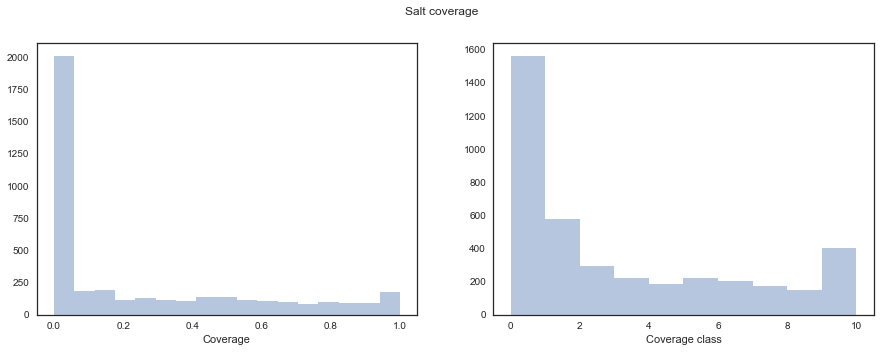

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
plt.show()

In [9]:
train_df.head()

,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


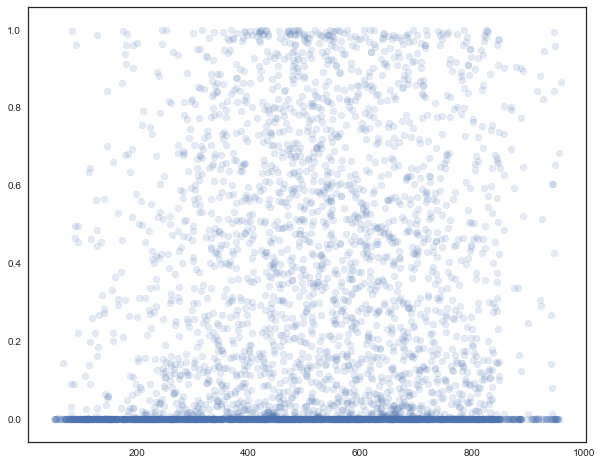

In [10]:
plt.figure(figsize=(10, 8))
plt.scatter(train_df.z, train_df.coverage, alpha=.15)
plt.show()

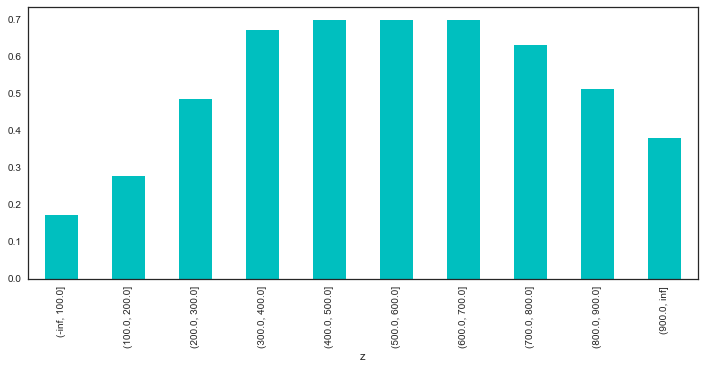

In [11]:
z_cut = pd.cut(train_df.z, [-np.Inf, 100, 200, 300, 400, 500, 600, 700, 800, 900, np.Inf])
c_cut = pd.cut(train_df.coverage, [-np.Inf, 0.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, np.Inf], labels=range(11))
train_df["c1"] = (train_df.coverage > 0).astype("int")
train_df["z_cut"] = z_cut
train_df["c_cut"] = c_cut

z_group = train_df.groupby(z_cut)
(z_group.c1.sum() / z_group.c1.size()).plot(kind="bar", color="c", figsize=(12, 5))
plt.show()

## 5fold-split --seed 123

In [12]:
from sklearn.model_selection import StratifiedKFold

X = np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1)
Y = np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1)
y = train_df.c_cut.values.copy()

skf = StratifiedKFold(n_splits=5, random_state=123)
skf.get_n_splits(X, y)
kfold_index = [ob for ob in skf.split(X, y)]

In [13]:
y.shape

(4000,)

In [14]:
for train_idx, valid_idx in kfold_index:
    print(train_idx.shape, valid_idx.shape)

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


In [16]:
def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test / 2.0

def filter_image(img):
    if img.sum() < 100:
        return np.zeros(img.shape)
    else:
        return img

import glob
glob.glob("./models/{}*.hdf5".format(exp_code))

['./models\\017-model-resnet-fold-0.hdf5',
 './models\\017-model-resnet-fold-1.hdf5',
 './models\\017-model-resnet-fold-2.hdf5',
 './models\\017-model-resnet-fold-3.hdf5',
 './models\\017-model-resnet-fold-4.hdf5']

## user defined loss & metric

In [17]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [18]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > .45], tf.float64)

## search threshold

In [19]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [20]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [21]:
thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

(3196,) (804,)
.\017-model-resnet-fold-0.hdf5


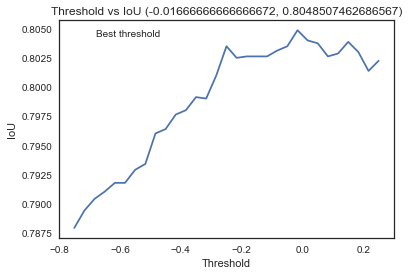

(3199,) (801,)
.\017-model-resnet-fold-1.hdf5


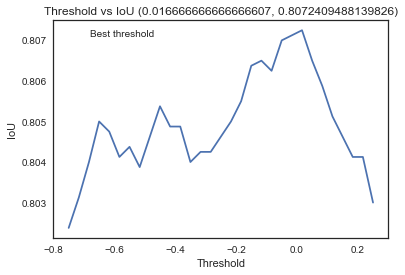

(3200,) (800,)
.\017-model-resnet-fold-2.hdf5


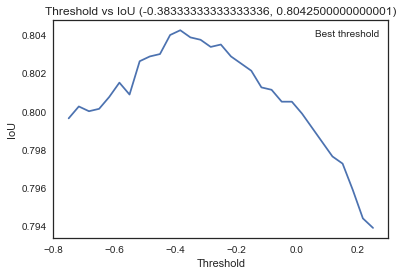

(3201,) (799,)
.\017-model-resnet-fold-3.hdf5


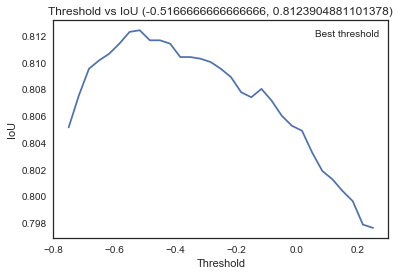

(3204,) (796,)
.\017-model-resnet-fold-4.hdf5


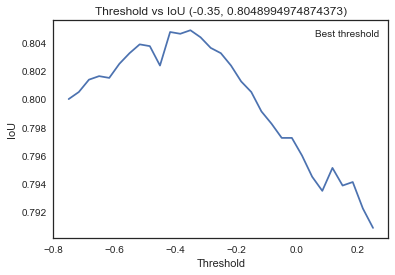

0.8067263361360428 0.003011141353417062


In [22]:
model_filepaths = [
    '.\\{}-model-resnet-fold-0.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-1.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-2.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-3.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-4.hdf5'.format(exp_code)
]

threshold_best_stack = []
iou_best_stack = []

for (train_idx, valid_idx), model_filepath in zip(kfold_index, model_filepaths):
    print(train_idx.shape, valid_idx.shape)
    print(model_filepath)
    
    ## preds_valid
    X_valid = X[valid_idx, :]
    Y_valid = Y[valid_idx, :]
    
    custom_objects = {
        'my_iou_metric': my_iou_metric,
        'lovasz_loss': lovasz_loss
    }

    model = load_model(model_filepath, custom_objects=custom_objects)
    preds_valid = predict_result(model, X_valid, img_size_target)
    
    ## Scoring for last model
    thresholds = np.linspace(-0.75, 0.25, 31)
    ious = np.array([get_iou_vector(Y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])
    
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    threshold_best_stack.append(threshold_best)
    iou_best_stack.append(iou_best)

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    plt.show()
    
print(np.mean(iou_best_stack), np.std(iou_best_stack))

(3196,) (804,)
.\016-model-resnet-fold-0.hdf5


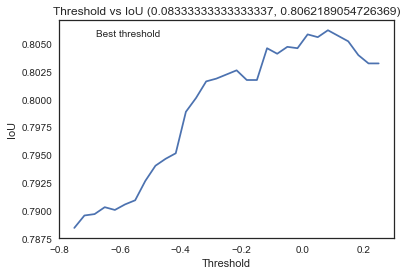

(3199,) (801,)
.\016-model-resnet-fold-1.hdf5


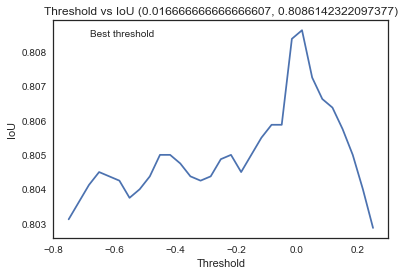

(3200,) (800,)
.\016-model-resnet-fold-2.hdf5


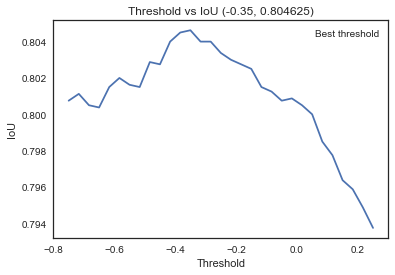

(3201,) (799,)
.\016-model-resnet-fold-3.hdf5


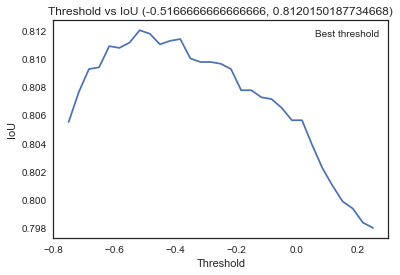

(3204,) (796,)
.\016-model-resnet-fold-4.hdf5


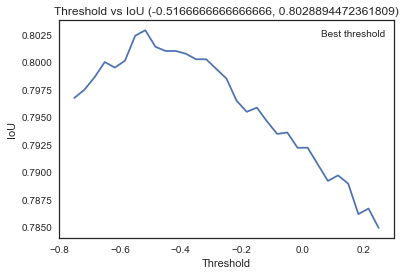

0.8068725207384044 0.0031881744556818614


In [67]:
model_filepaths = [
    '.\\{}-model-resnet-fold-0.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-1.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-2.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-3.hdf5'.format(exp_code),
    '.\\{}-model-resnet-fold-4.hdf5'.format(exp_code)
]

threshold_best_stack = []
iou_best_stack = []

for (train_idx, valid_idx), model_filepath in zip(kfold_index, model_filepaths):
    print(train_idx.shape, valid_idx.shape)
    print(model_filepath)
    
    ## preds_valid
    X_valid = X[valid_idx, :]
    Y_valid = Y[valid_idx, :]
    
    custom_objects = {
        'my_iou_metric': my_iou_metric,
        'lovasz_loss': lovasz_loss
    }

    model = load_model(model_filepath, custom_objects=custom_objects)
    preds_valid = predict_result(model, X_valid, img_size_target)
    
    ## Scoring for last model
    thresholds = np.linspace(-0.75, 0.25, 31)
    ious = np.array([get_iou_vector(Y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])
    
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    threshold_best_stack.append(threshold_best)
    iou_best_stack.append(iou_best)

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    plt.show()
    
print(np.mean(iou_best_stack), np.std(iou_best_stack))

(3196,) (804,)
.\015-model-resnet-fold-0.hdf5


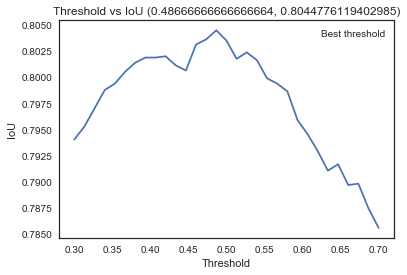

(3199,) (801,)
.\015-model-resnet-fold-1.hdf5


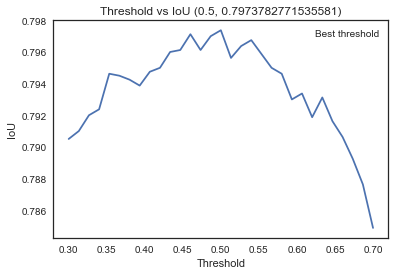

(3200,) (800,)
.\015-model-resnet-fold-2.hdf5


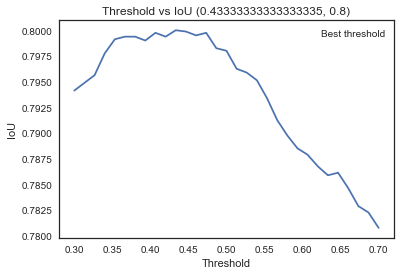

(3201,) (799,)
.\015-model-resnet-fold-3.hdf5


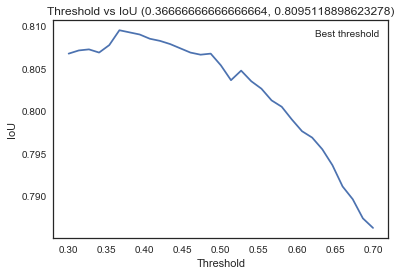

(3204,) (796,)
.\015-model-resnet-fold-4.hdf5


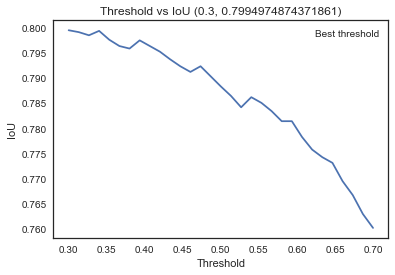

0.802173053278674 0.004336823820274877


In [39]:
model_filepaths = [
    '.\\015-model-resnet-fold-0.hdf5',
    '.\\015-model-resnet-fold-1.hdf5',
    '.\\015-model-resnet-fold-2.hdf5',
    '.\\015-model-resnet-fold-3.hdf5',
    '.\\015-model-resnet-fold-4.hdf5'
]

threshold_best_stack = []
iou_best_stack = []

for (train_idx, valid_idx), model_filepath in zip(kfold_index, model_filepaths):
    print(train_idx.shape, valid_idx.shape)
    print(model_filepath)
    
    ## preds_valid
    X_valid = X[valid_idx, :]
    Y_valid = Y[valid_idx, :]
    
    model = load_model(model_filepath, custom_objects={'my_iou_metric_2': my_iou_metric_2})
    preds_valid = predict_result(model, X_valid, img_size_target)
    
    ## Scoring for last model
    thresholds = np.linspace(0.3, 0.7, 31)
    ious = np.array([get_iou_vector(Y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])
    
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    threshold_best_stack.append(threshold_best)
    iou_best_stack.append(iou_best)

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    plt.show()
    
print(np.mean(iou_best_stack), np.std(iou_best_stack))

(3196,) (804,)
.\015-model-resnet-fold-0.hdf5


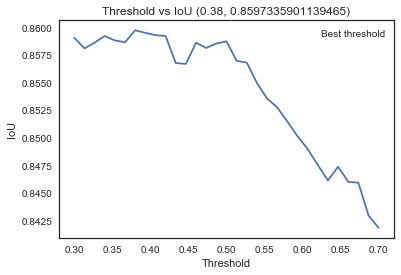

(3199,) (801,)
.\015-model-resnet-fold-1.hdf5


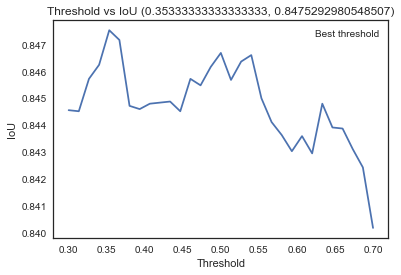

(3200,) (800,)
.\015-model-resnet-fold-2.hdf5


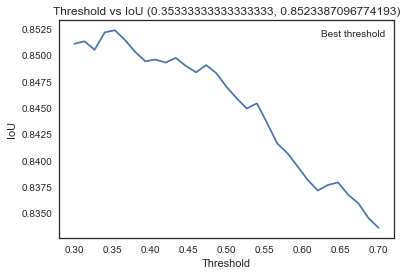

(3201,) (799,)
.\015-model-resnet-fold-3.hdf5


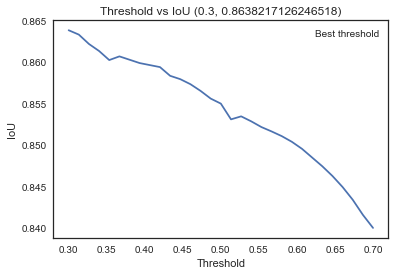

(3204,) (796,)
.\015-model-resnet-fold-4.hdf5


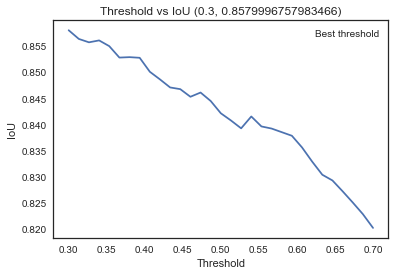

0.856284597253843 0.005724865886732961


In [21]:
model_filepaths = [
    '.\\015-model-resnet-fold-0.hdf5',
    '.\\015-model-resnet-fold-1.hdf5',
    '.\\015-model-resnet-fold-2.hdf5',
    '.\\015-model-resnet-fold-3.hdf5',
    '.\\015-model-resnet-fold-4.hdf5'
]

threshold_best_stack = []
iou_best_stack = []

for (train_idx, valid_idx), model_filepath in zip(kfold_index, model_filepaths):
    print(train_idx.shape, valid_idx.shape)
    print(model_filepath)
    
    ## preds_valid
    X_valid = X[valid_idx, :]
    Y_valid = Y[valid_idx, :]
    
    model = load_model(model_filepath, custom_objects={'my_iou_metric_2': my_iou_metric_2})
    preds_valid = predict_result(model, X_valid, img_size_target)
    
    ## Scoring for last model
    thresholds = np.linspace(0.3, 0.7, 31)
    ious = np.array([iou_metric(Y_valid.reshape((-1, img_size_target, img_size_target)), [filter_image(img) for img in preds_valid > threshold]) for threshold in tqdm_notebook(thresholds)])
    
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]
    
    threshold_best_stack.append(threshold_best)
    iou_best_stack.append(iou_best)

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    plt.show()
    
print(np.mean(iou_best_stack), np.std(iou_best_stack))

## predict test

threshold_best_stack = [0.5133333333333333, 0.38, 0.43333333333333335, 0.36666666666666664, 0.3]
threshold_best_stack = [.083333, .016667, -.35, -.51667, -.51667]

In [68]:
img_size_target = 101

In [70]:
exp_code = "016"

def predict_result(model, x_test, img_size_target): # predict both orginal and reflect x
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(a) for a in model.predict(np.array([np.fliplr(x) for x in x_test])).reshape(-1, img_size_target, img_size_target)])
    return preds_test / 2.0

def filter_image(img):
    if img.sum() < 50:
        return np.zeros(img.shape)
    else:
        return img

model_filepaths = [
    './models\\{}-model-resnet-fold-0.hdf5'.format(exp_code),
    './models\\{}-model-resnet-fold-1.hdf5'.format(exp_code),
    './models\\{}-model-resnet-fold-2.hdf5'.format(exp_code),
    './models\\{}-model-resnet-fold-3.hdf5'.format(exp_code),
    './models\\{}-model-resnet-fold-4.hdf5'.format(exp_code)
]
threshold_best_stack = [.083333, .016667, -.35, -.51667, -.51667]

In [71]:
# Loading of training/testing ids and depths

train_df = pd.read_csv("./data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("./data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [72]:
sum(threshold_best_stack)

-1.28334

In [73]:
x_test = np.array([(np.array(load_img("./data/test/images/{}.png".format(idx), grayscale = True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [74]:
preds_test = np.zeros((18000,101,101))
preds_test.shape

(18000, 101, 101)

In [75]:
# vote

custom_objects = {
    'my_iou_metric': my_iou_metric,
    'lovasz_loss': lovasz_loss
}

for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath, custom_objects=custom_objects)
    pred_temp = predict_result(model, x_test, img_size_target)
    print(pred_temp.shape, preds_test.shape)
    preds_test += pred_temp > threshold_best
    keras.backend.clear_session()

./models\016-model-resnet-fold-0.hdf5 0.083333
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-1.hdf5 0.016667
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-2.hdf5 -0.35
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-3.hdf5 -0.51667
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-4.hdf5 -0.51667
(18000, 101, 101) (18000, 101, 101)


In [87]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [88]:
# avg

custom_objects = {
    'my_iou_metric': my_iou_metric,
    'lovasz_loss': lovasz_loss
}

for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath, custom_objects=custom_objects)
    pred_temp = predict_result(model, x_test, img_size_target)
    print(pred_temp.shape, preds_test.shape)
    preds_test += sigmoid(pred_temp - threshold_best)
    keras.backend.clear_session()

./models\016-model-resnet-fold-0.hdf5 0.083333
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-1.hdf5 0.016667
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-2.hdf5 -0.35
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-3.hdf5 -0.51667
(18000, 101, 101) (18000, 101, 101)
./models\016-model-resnet-fold-4.hdf5 -0.51667
(18000, 101, 101) (18000, 101, 101)


In [89]:
np.save("./{}-pred-test-sigmoid-avg.npy".format(exp_code), preds_test)

In [90]:
preds_test.shape

(18000, 101, 101)

In [91]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_encode2(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [98]:
pred_th = preds_test > 2.5

import time
t1 = time.time()
pred_dict = {idx: rle_encode2(filter_image(pred_th[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 5.715189695358276 s


In [99]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./result/{}-submission-lovasz-loss-sigmoid-avg-th2-5.csv'.format(exp_code))

In [100]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,8 13 105 16 204 19 305 18 405 18 507 17 608 17...
64dba827d6,
0a3a8a5f37,
329563756f,1 4746 4748 99 4849 99 4950 98 5051 98 5152 98...
f6cba2e890,


## load & change th

In [5]:
preds_test = np.load("./{}-pred-test-sum.npy".format(exp_code))
print(preds_test.shape)

(18000, 101, 101)


In [45]:
pred_th = preds_test > -4

import time
t1 = time.time()
pred_dict = {idx: rle_encode2(filter_image(pred_th[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

Usedtime = 2.076235771179199 s


In [46]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('./result/{}-submission-lovasz-loss-th-ng4.csv'.format(exp_code))

In [47]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,1 23 102 22 203 22 304 21 405 20 506 19 607 18...
64dba827d6,
0a3a8a5f37,
329563756f,1 4847 4849 100 4950 99 5051 99 5152 99 5253 9...
f6cba2e890,


In [35]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,207 1 405 6 506 6 513 3 607 11 708 13 809 13 9...
64dba827d6,
0a3a8a5f37,
329563756f,1 4645 4647 100 4748 99 4849 99 4950 98 5051 9...
f6cba2e890,


In [12]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,3 1 102 1 104 1 203 5 304 3 405 6 506 3 510 1 ...
64dba827d6,
0a3a8a5f37,
329563756f,1 4948 4950 100 5051 99 5152 98 5253 97 5354 9...
f6cba2e890,


In [18]:
sub.head(10)

,rle_mask
id,
353e010b7b,
5439dbbddf,
71bab9f311,
52551f7a80,
512d8d9997,94 8 194 9 296 8 396 9 495 11 595 12 696 12 79...
64dba827d6,
0a3a8a5f37,
329563756f,1 9077 9084 91 9189 83 9293 76 9394 71 9495 66...
f6cba2e890,


## no

In [11]:
# vote
for model_filepath, threshold_best in zip(model_filepaths, threshold_best_stack):
    print(model_filepath, threshold_best)
    model = load_model(model_filepath)
    pred_temp = (predict_result(model, x_test, img_size_target) > threshold_best)
    print(pred_temp.shape, preds_test.shape)
    preds_test += pred_temp
    
preds_test = preds_test >= 3

.\007-model-resnet-fold-0.hdf5 0.5133333333333333
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-1.hdf5 0.38
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-2.hdf5 0.43333333333333335
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-3.hdf5 0.36666666666666664
(18000, 101, 101) (18000, 101, 101)
.\007-model-resnet-fold-4.hdf5 0.3
(18000, 101, 101) (18000, 101, 101)
